# Variational Relevance Vector Machine: Comparison of VRVR, RVR and SVR

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error as mse
from vrvm import VRVR
from rvm import SparseBayesianLearner
from sklearn.datasets import load_boston
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import scale
%matplotlib inline


## Regression

### Synthetic example

In [42]:
# parameters
n = [10,15,20,25,40,60,100,200,300,500,1000]


def comparison(n):
    '''
    Comparing RVR, VRVR and SVR 
    '''
    # generate data set
    Xc       = np.ones([n,1])
    Xc[:,0]  = np.linspace(-5,5,n)
    Yc       = 10*np.sinc(Xc[:,0]) + np.random.normal(0,1,n)
    X,x,Y,y  = train_test_split(Xc,Yc,test_size = 0.4, random_state = 0)

    # train rvm with fixed-point optimization
    rvr = SparseBayesianLearner(learn_type = "regression",method="fixed-point",alpha_max  = 1,
                                                                           kernel     = "gaussian",
                                                                           scaler     = 1)
    rvr.fit(X,Y)
    y_rvr,var = rvr.predictive_distribution(x)
    rvr_err   = mse(y_rvr,y)
    rvr_rvs       = np.sum(rvr.active[1:])
    
    # train variational rvm
    vrvr       = VRVR(X,Y,kernel = "rbf", scaler = 1,prune_thresh = 1e-2)
    vrvr.fit()
    y_vrvr,var_vrvr = vrvr.predict_dist(x)
    vrvr_err        = mse(y_vrvr,y)
    vrvr_rvs        = np.sum(vrvr.active[1:])

    # train svr
    svr        = GridSearchCV(SVR(kernel = "rbf"), param_grid = {'gamma':np.logspace(-2,2,5),
                                                             'C':np.logspace(-2,2,5)},
                                                   cv = 5)
    svr.fit(X,Y)
    y_svr      = svr.predict(x)
    svr_err    = mse(y_svr,y)
    svr_svs    = np.shape(svr.best_estimator_.support_vectors_)[0]
    
    return {'rvr':[rvr_err,rvr_rvs],'vrvr':[vrvr_err,vrvr_rvs],
            'svr':[svr_err,svr_svs]}

mse_rvr,mse_svr,mse_vrvr = [],[],[]
rvs_rvr,rvs_svr,rvs_vrvr = [],[],[]

for n__obs in n:
    for i in range(n_sim)
    data = comparison(n_sim)
    # relevance vector machine
    


### Boston housing example

In [31]:


# number of runs
n_sim       = 100 

# load data , split training & test
boston      = load_boston()
XXb,YYb     = scale(boston["data"]),boston["target"]


# MSE & Relevant Vectors
mse_rvr,mse_vrvr,mse_svr = [],[],[]
rvs_rvr,rvs_vrvr,rvs_svr = [],[],[]

for i in range(n_sim):
    Xb,xb,Yb,yb = train_test_split(XXb,YYb,test_size = 0.7)
    
    # RVM
    rvrb = SparseBayesianLearner(method = "fixed-point",learn_type = "regression",alpha_max=1e+3,
                                                                                  scaler = 10,
                                                                                  kernel="poly",
                                                                                  p_order = 3)
    rvrb.fit(Xb,Yb)
    y_rvrb,var  = rvrb.predictive_distribution(xb)
    rvrb_err   = mse(y_rvrb,yb)
    rvrb_rvs   = np.sum(rvrb.active[1:])
    mse_rvr.append(rvrb_err); rvs_rvr.append(rvrb_rvs)

    # VRVM
    vrvrb            = VRVR(Xb,Yb,kernel = "poly", scaler = 10, prune_thresh = 1e-4, order = 3)
    vrvrb.fit()
    y_vrvr,var_vrvr  = vrvrb.predict_dist(xb)
    vrvrb_err        = mse(y_vrvr,yb)
    vrvrb_rvs        = np.sum(vrvrb.active[1:])
    mse_vrvr.append(vrvrb_err); rvs_vrvr.append(vrvrb_rvs)
    
    # SVR
    svr              = GridSearchCV( SVR(kernel='poly',coef0=1,degree=3),
                                     param_grid = {"gamma":np.logspace(-2,2,5),
                                                   "C":np.logspace(-3,3,7)},
                                     cv = 5)
    svr.fit(Xb,Yb)
    y_svr            = svr.predict(xb)
    svr_err          = mse(y_svr,yb)
    svr_rvs          = np.shape(svr.best_estimator_.support_vectors_)[0]
    mse_svr.append(svr_err); rvs_svr.append(svr_rvs)
    

print "VRVR median MSE = {0}, median number of RVs = {1}".format(np.median(mse_vrvr),np.median(rvs_vrvr))
print "RVR median MSE = {0}, median number of RVs = {1}".format(np.median(mse_rvr),np.median(rvs_rvr))
print "SVR median MSE = {0}, median number of SVs = {1}".format(np.median(mse_svr),np.median(rvs_svr))




VRVR median MSE = 18.3991171027, median number of RVs = 35.0
RVR median MSE = 17.8692725812, median number of RVs = 21.0
SVR median MSE = 18.5061779678, median number of SVs = 77.0


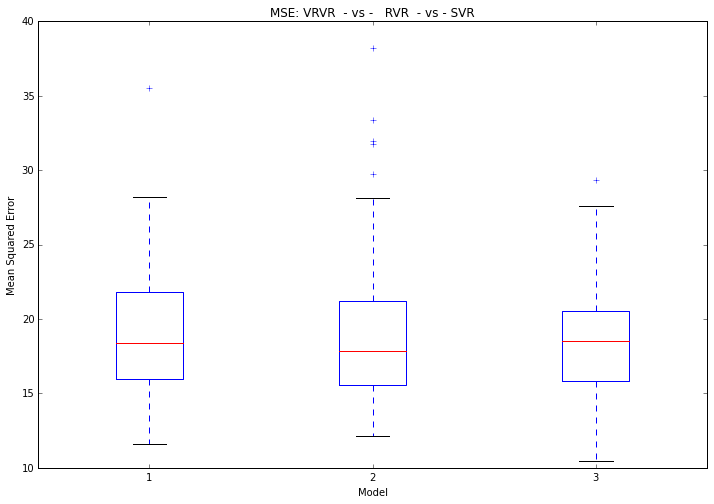

In [33]:
# comparing prediction accuracy on test set in terms of MSE
plt.figure(figsize= (12,8))
plt.boxplot((mse_vrvr,mse_rvr,mse_svr))
plt.title("MSE: VRVR  - vs -   RVR  - vs - SVR")
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.show()

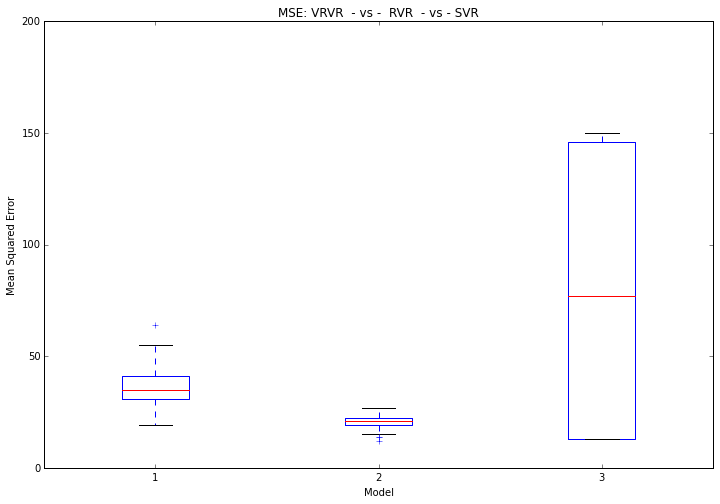

In [34]:
# comparing model sparsity interms of relevant and support vectors
plt.figure(figsize = (12,8))
plt.boxplot((rvs_vrvr,rvs_rvr,rvs_svr))
plt.title("MSE: VRVR  - vs -  RVR  - vs - SVR")
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.ylim((0,200))
plt.show()